In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

df_vul = pd.read_csv('./Climate_Ready_Boston_Social_Vulnerability.csv')
df_bus_list = ('./20220516-MainStreet_BusinessList.csv')
district4_vul = df_vul.loc[df_vul['Name'].isin(['Dorchester', 'Rosindale', 'Mattapan'])]
x = district4_vul.sort_values('Name')


district4_geo_id = district4_vul['GEOID10']

In [ ]:
pip install geopandas

In [ ]:
import geopandas as gpd
import folium
#read geojson file
data = gpd.read_file('Climate_Ready_Boston_Social_Vulnerability.geojson')
# print(district4_geo_id)
district4_geo_id = district4_geo_id.apply(lambda x: str(x))


vulnerable = data.loc[data['GEOID10'].isin(district4_geo_id)]
#Convert Geopandas Multipolygon to Polygon
vulnerable_e = vulnerable.explode()
map_1=folium.Map(location=[42.364506, -71.038887],zoom_start=12)

data = gpd.read_file('./City_Council_Districts_View.geojson')
dis4 = data.loc[data['DISTRICT'] == 4]
dis4_e = dis4.explode()
style_function = lambda x: {'fillColor': '#ff7300' , 'color': '#ff7300' }

folium.GeoJson(data=dis4_e["geometry"]).add_to(map_1)
folium.GeoJson(data=vulnerable["geometry"], overlay = True, style_function= style_function).add_to(map_1)

map_1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  app.launch_new_instance()


# New Section

In [ ]:
from shapely.geometry import Point

#get location in district4
df['within_dis4'] = ""

within_dis4 = []
for lon,lat in zip(df['longitude'], df['latitude']):
    pt = Point(lon, lat)
    within = pt.within(dis4_e['geometry'].values[0])
    within_dis4.append(within)

# update values in the that column, values: True/False
df['within_dis4'] = within_dis4
df_within4 = df[df.within_dis4==True]
df_within4 = df_within4.reset_index(drop=True)
dis4_business = df_within4['business_classes'].unique()

#count each business in district4
busi_dist4 = df_within4['business_classes'].value_counts()

#get the missing business in district4
# mis_business = list(set(all_business)-set(dis4_business))
# mis_business

In [ ]:
dis1 = data.loc[data['DISTRICT'] == 1]
#Convert Geopandas Multipolygon to Polygon
dis1_e = dis1.explode()

#get location in district4
df['within_dis1'] = ""

within_dis1 = []
for lon,lat in zip(df['longitude'], df['latitude']):
    pt = Point(lon, lat)
    within = pt.within(dis1_e['geometry'].values[0])
    within_dis1.append(within)

# update values in the that column, values: True/False
df['within_dis1'] = within_dis1
df_within1 = df[df.within_dis1==True]
df_within1 = df_within1.reset_index(drop=True)

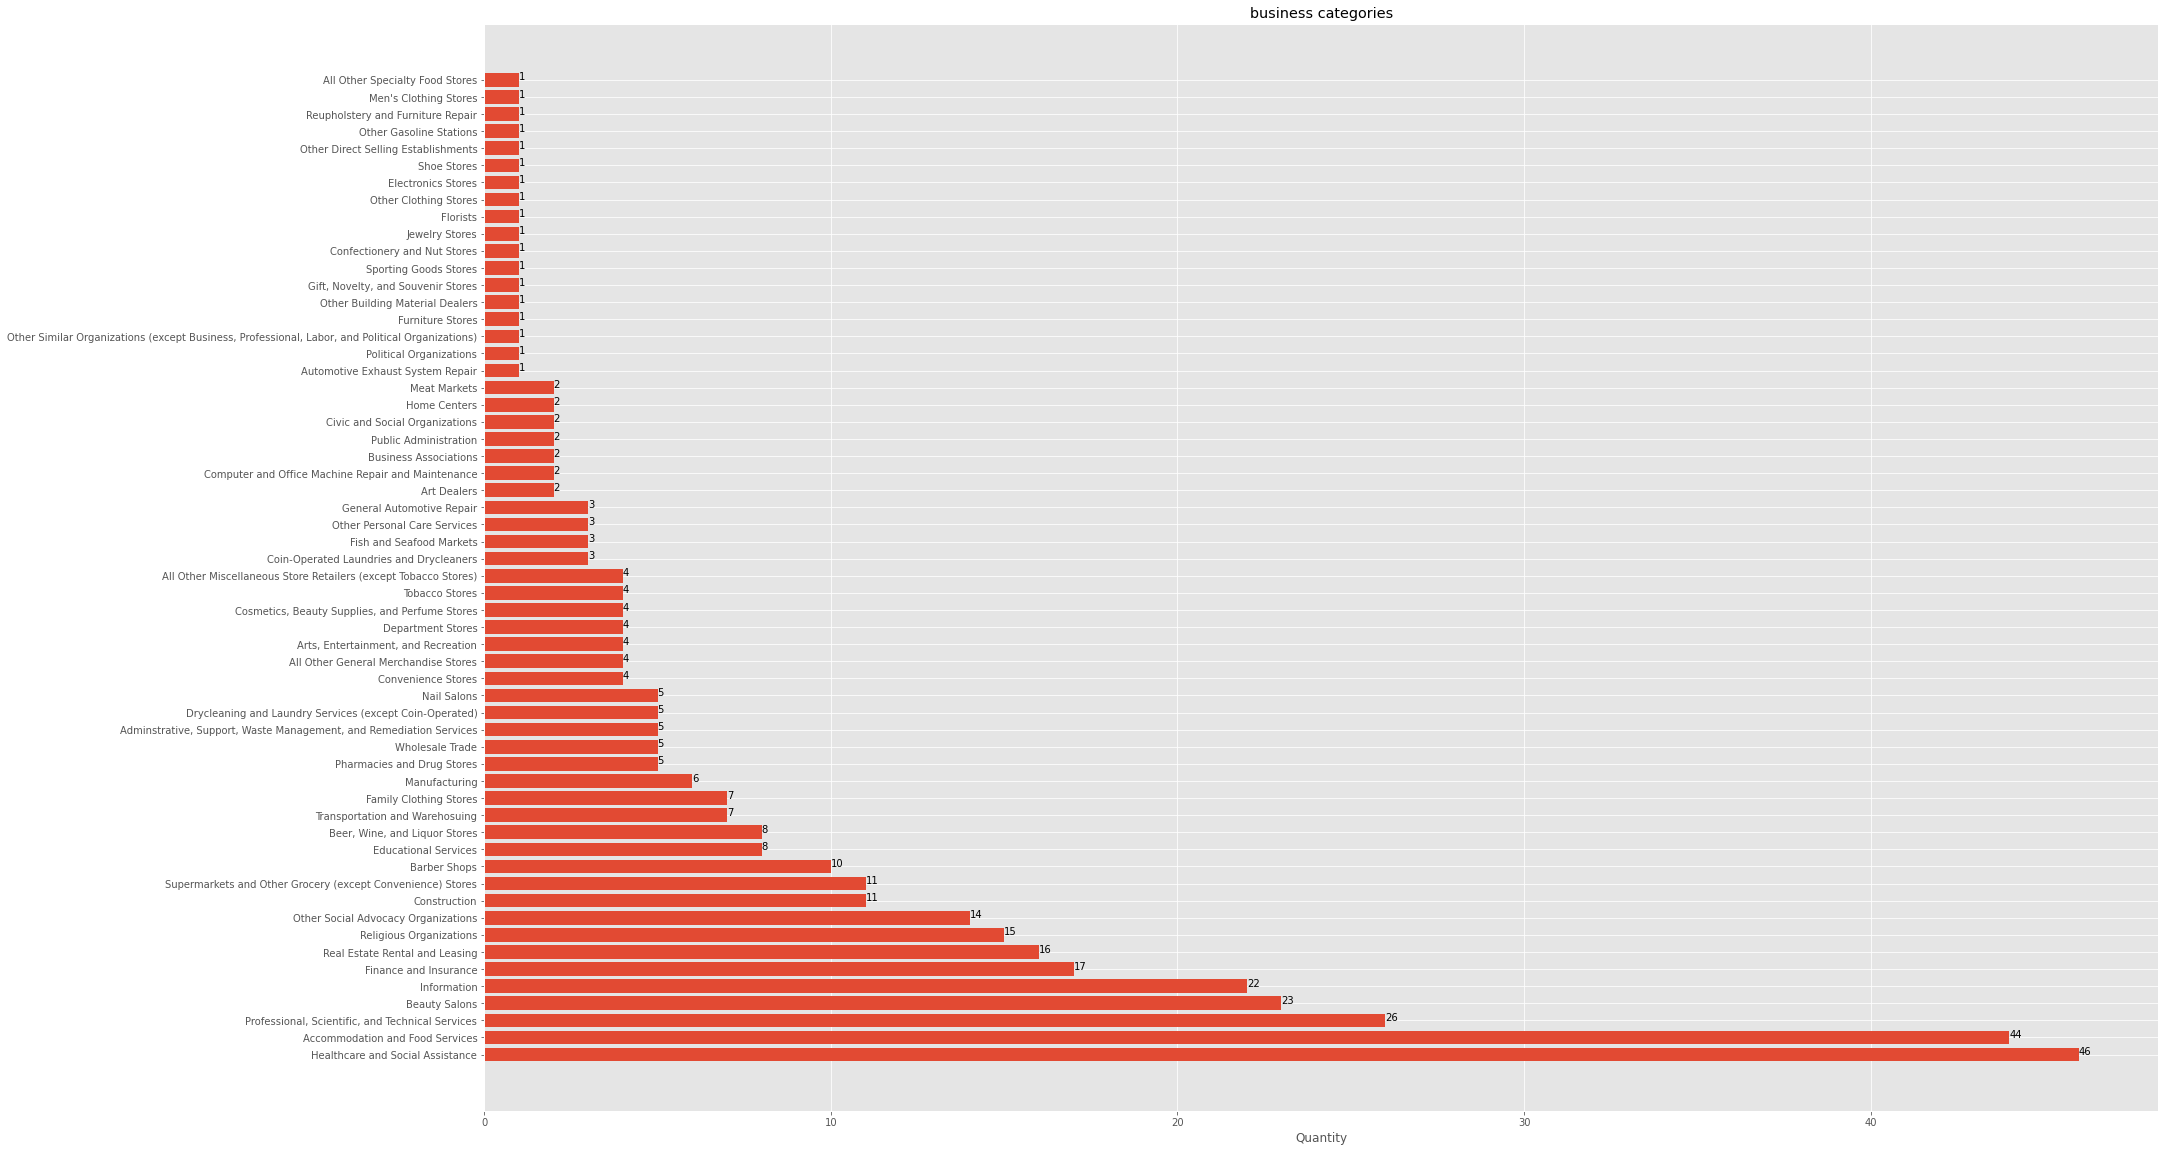

In [ ]:
import matplotlib.pyplot as plt


plt.style.use('ggplot')
plt.figure(figsize=(30,20))
plt.barh(busi_dist4.index, busi_dist4.values)

for index, value in enumerate(busi_dist4.values):
    plt.text(value, index, str(value))
#plot Retail Trade and Other services from 6digits, others from 2digits
plt.title('business categories')
plt.xlabel('Quantity')
plt.show()

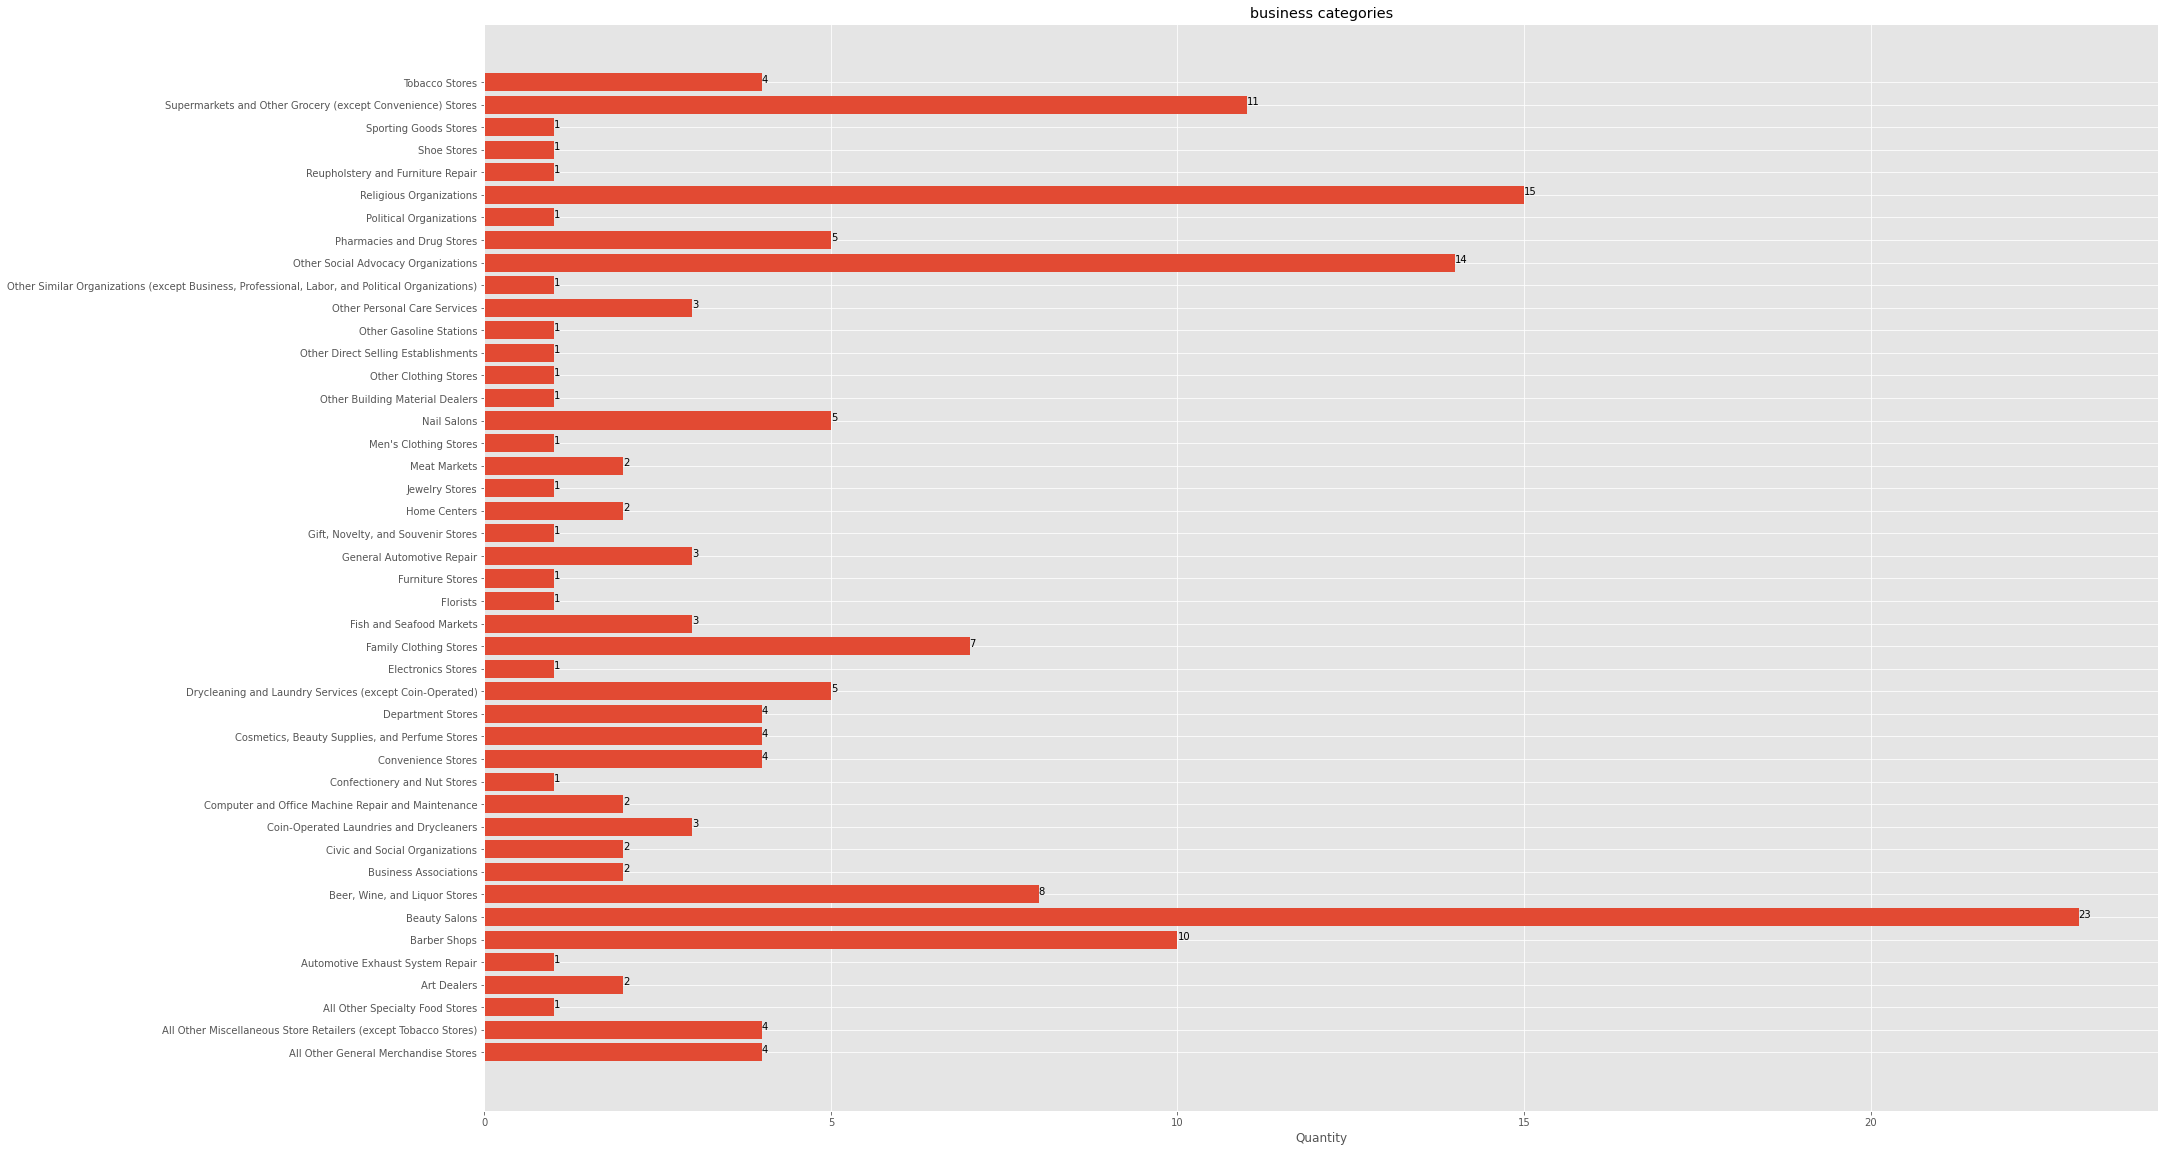

In [ ]:
dis4_within4_1 = df_within4.loc[df_within4['business_label'] == 1]
busi_dist4_1 = dis4_within4_1.groupby('business_classes')['...1'].count()


plt.style.use('ggplot')
plt.figure(figsize=(30,20))
plt.barh(busi_dist4_1.index, busi_dist4_1.values)

for index, value in enumerate(busi_dist4_1.values):
    plt.text(value, index, str(value))
#only plot Retail Trade and Other services
plt.title('business categories')
plt.xlabel('Quantity')
plt.show()

In [ ]:
import folium
import webbrowser as wb
#get two centroid business of dist4
centroid1 = [42.3052965,-71.0797222]
centroid2 = [42.2984378,-71.0605241]

#Accommodation and Food Services class has the most quantity
df_fs = df_within4.loc[df_within4['business_classes'] == 'Accommodation and Food Services']

map_1=folium.Map(location=[(centroid1[0]+centroid2[0])/2, (centroid1[1]+centroid2[1])/2],zoom_start=15)
df_fs.apply(lambda row:folium.Marker(
    location=[row["latitude"], row["longitude"]],
    popup=row["business_classes"],
    icon=folium.map.Icon(color='green') ).add_to(map_1),axis=1)

folium.Circle(location=[42.3052965,-71.0797222],radius=1000,color = 'green', fill=True).add_to(map_1)
folium.Circle(location=[42.2984378,-71.0605241],radius=1000,color = 'blue', fill=True).add_to(map_1)
map_1

In [ ]:
import haversine as hs

df_within4_d = df_within4.loc[:,['latitude','longitude','business_classes']]

In [ ]:
#count business in specific area, if one business more than 10 stores, it will be assign overlap
def count_overlap(df):
  dist_c1 = []
  dist_c2 = []
  df_ind = df['business_classes'].values[0]
  lat = df['latitude'].values
  lng = df['longitude'].values
  for i in range(len(lat)):
    loc = [lat[i],lng[i]]
    dist_1 = hs.haversine(centroid1,loc)
    dist_2 = hs.haversine(centroid2,loc)
    if dist_1 <= 1:
      dist_c1.append(dist_1)
    if dist_2 <= 1:
      dist_c2.append(dist_2)
  if len(dist_c1) >= 10:
    print(df_ind + " overlap in C1")
  if len(dist_c2) >= 10:
    print(df_ind +" overlap in C2")

#loop every business classes
df_busi = df_within4_d['business_classes'].value_counts()

for m in range(len(df_busi.index)):
  count_df = df_within4_d.loc[df_within4_d['business_classes'] == df_busi.index[m]]
  count_overlap(count_df)
#the result shows that these business overlap in which area.

NameError: ignored

In [ ]:


df_HS = df_within4_d[(df_within4_d['business_classes'] == 'Healthcare and Social Assistance')]
df_AF = df_within4_d[(df_within4_d['business_classes'] == 'Accommodation and Food Services')]
df_BS = df_within4_d[(df_within4_d['business_classes'] == 'Beauty Salons')]
df_IN = df_within4_d[(df_within4_d['business_classes'] == 'Information')]
df_RO = df_within4_d[(df_within4_d['business_classes'] == 'Religious Organizations')]
df_PS = df_within4_d[(df_within4_d['business_classes'] == 'Professional, Scientific, and Technical Services')]
df_FI = df_within4_d[(df_within4_d['business_classes'] == 'Finance and Insurance')]


map_2=folium.Map(location=[(centroid1[0]+centroid2[0])/2, (centroid1[1]+centroid2[1])/2],zoom_start=15)
df_HS.apply(lambda row:folium.Marker(
    location=[row["latitude"], row["longitude"]],
    popup=row["business_classes"],
    icon=folium.map.Icon(color='green') ).add_to(map_2),axis=1)
df_AF.apply(lambda row:folium.Marker(
    location=[row["latitude"], row["longitude"]],
    popup=row["business_classes"],
    icon=folium.map.Icon(color='blue') ).add_to(map_2),axis=1)
df_BS.apply(lambda row:folium.Marker(
    location=[row["latitude"], row["longitude"]],
    popup=row["business_classes"],
    icon=folium.map.Icon(color='red') ).add_to(map_2),axis=1)
df_IN.apply(lambda row:folium.Marker(
    location=[row["latitude"], row["longitude"]],
    popup=row["business_classes"],
    icon=folium.map.Icon(color='purple') ).add_to(map_2),axis=1)
df_RO.apply(lambda row:folium.Marker(
    location=[row["latitude"], row["longitude"]],
    popup=row["business_classes"],
    icon=folium.map.Icon(color='gray') ).add_to(map_2),axis=1)
df_PS.apply(lambda row:folium.Marker(
    location=[row["latitude"], row["longitude"]],
    popup=row["business_classes"],
    icon=folium.map.Icon(color='orange') ).add_to(map_2),axis=1)
df_FI.apply(lambda row:folium.Marker(
    location=[row["latitude"], row["longitude"]],
    popup=row["business_classes"],
    icon=folium.map.Icon(color='black') ).add_to(map_2),axis=1)


folium.Circle(location=[42.3052965,-71.0797222],radius=1000,color = 'green', fill=True).add_to(map_2)
folium.Circle(location=[42.2984378,-71.0605241],radius=1000,color = 'blue', fill=True).add_to(map_2)
map_2